## 準備
- データは iris を使う
- 分類アルゴリズムは サポートベクターマシン を使う

In [19]:
# 結果を見やすくするために警告を非表示にする
import warnings

warnings.filterwarnings('ignore')

In [20]:
# データの準備
from sklearn.datasets import load_iris

iris = load_iris()

In [21]:
# 教師データの分割
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target,
                                                    random_state=0)

## モデルにはパラメータが必要
- デフォルトでいろいろ設定されている
- 良いパラメータを選ぶことができれば、さらによいモデルが期待できる(逆もまたしかり)

In [22]:
from sklearn.svm import SVC

# ハイパーパラメータの設定によって正答率がかなり変わる

svm_1 = SVC(C=0.001, gamma=0.1)
svm_1.fit(X_train, y_train)
print(f"svm1(C=0.001, gamma=0.1): {svm_1.score(X_test, y_test):.2f}")


svm_2 = SVC(C=0.1, gamma=0.1)
svm_2.fit(X_train, y_train)
print(f"svm2(C=0.1, gamma=0.1): {svm_2.score(X_test, y_test):.2f}")


svm_3 = SVC(C=0.1, gamma=10)
svm_3.fit(X_train, y_train)
print(f"svm3(C=0.1, gamma=10): {svm_3.score(X_test, y_test):.2f}")

svm1(C=0.001, gamma=0.1): 0.24
svm2(C=0.1, gamma=0.1): 0.92
svm3(C=0.1, gamma=10): 0.29


## 単順なグリッドサーチ
- サポートベクターマシンには2つのパラメータがある
    - `gamma` と `C`
    - 2つのパラメータに対して for を回せばOK

In [23]:
from sklearn.svm import SVC

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)

        # 学習
        svm.fit(X_train, y_train)

        # 精度(正答率)を計算
        score = svm.score(X_test, y_test)

        if score > best_score:
            best_score = score
            best_parameters = {"C": C, "gamma": gamma}

In [24]:
print(f"Best score: {best_score:.2f}")
print(f"Best parameters: {best_parameters}")

Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


## パラメータの過学習の危険性と検証データ
### さっきのスコア(0.97)をみて、「97%の精度を持つモデルを見つけた！」と主張するのか？
- さまざまなパラメータを試して、そのテストデータに対して最も再度の高い組み合わせを選んだ
	- テストデータをパラメータチューニングに使ってしまった！
- **モデルの評価には、モデル構築に用いていないデータ**が必要！
	- そうしないと、情報漏洩みたいなことになっちゃう

### 検証データを使う
- 学習データを更に分割する
- 検証データを使って最良のパラメータを選択したら、そのパラメータを用いてモデルを最構築
	- このとき、訓練データだけでなく検証データも使う
	- 可能な限りデータを有効に使うのよ

In [25]:
# 教師データの分割
# 学習データ / 検証データ / テストデータ
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data,
                                                          iris.target,
                                                          random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,
                                                      y_trainval,
                                                      random_state=1)

In [26]:
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)

        # 学習時は学習データのみを使う
        svm.fit(X_train, y_train)

        # 精度の評価(≒パラメータの良さ)は検証データを基準にする
        score = svm.score(X_valid, y_valid)

        if score > best_score:
            best_score = score
            best_parameters = {"C": C, "gamma": gamma}

# 検証データに対するベストスコア
print(f"Best score: {best_score:.2f}")
print(f"Best parameters: {best_parameters}")

# 訓練データと検証データを使ってモデルを再構築
svm = SVC(**best_parameters)
svm.fit(X_trainval,  y_trainval)

# 最後の最後に テストデータ(これまで1度も使っていない) で評価
test_score = svm.score(X_test, y_test)

print(f"Test score: {test_score:.2f}")

Best score: 0.96
Best parameters: {'C': 10, 'gamma': 0.001}
Test score: 0.92


### 結果
- 検証データのスコア: 0.96 <- 低下！ さっきは0.97
	- モデルの訓練に使うデータ量が減ったの影響していそう
- テストデータのスコア: 0.92 <- 低下！ さっきは0.97
	- 汎化性能は低下
	- 新しいデータに対する精度として主張できるのは 97% じゃなくて 92% ということ


## 交差検証を用いたグリッドサーチ
- さっきの例は、 `C:  10, gamma: 0.001` を最良のパラメータとした
- でも、その前は `C: 100, gamma: 0.001` を最良だった
- 汎化性能をよりよく見積もるためには、訓練データと検証データの分割を1度だけ行なうのではなく、それぞれのパラメータの組み合わせについて交差検証を行なおう

In [27]:
import numpy as np
from sklearn.model_selection import cross_val_score

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)

        # 5分割交差検証
        # 6 * 6 * 5 = 180通りの組み合わせ
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)

        score = np.mean(scores)

        if score > best_score:
            best_score = score
            best_parameters = {"C": C, "gamma": gamma}

# 訓練データと検証データをあわせてモデルを再構築
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### ながれ
- 個々のパラメータに対して、交差検証の5つの分割に対して5つの精度が計算される
- 次に、個々のパラメータに対して、検証精度の平均値を計算する
- この中から平均値が最も大きいパラメータセットを選択する

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

![](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

### 交差検証を用いたグリッドサーチは `GridSearchCV` でいける

In [28]:
# パラメータの組み合わせを準備
param_grid = {
    "C":          [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}

param_grid

{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [29]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(SVC(), param_grid, cv=5)

In [30]:
# 教師データの分割(わざわざ検証データをつくらなくてもOK)
X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target,
                                                    random_state=0)

In [31]:
# fit() をCallすれば param_grid で指定したパラメータの組み合わせで交差検証が実行
# 交差検証で最も良いスコアだったパラメータを用いたモデル再構築までやってくれる
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [32]:
# テストデータでの評価も簡単
print(f"{grid_search.score(X_test, y_test):.2f}")

0.97


### 重要ポイント
- パラメータを選ぶのに、**テストデータを使わなかった**

In [33]:
# パラメータ
print(f"Best params:  {grid_search.best_params_}")

# best_score_: 学習データに対する交差検証の平均交差検証精度
#               中で trainとvalid に分割してるから間違えないように！
# score(X_test, y_test): 学習データ全体を用いて学習したモデルを用いた結果
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

Best params:  {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97


In [34]:
# 見やすくするためにDataFrameでみる
import pandas as pd

results = pd.DataFrame(grid_search.cv_results_)

In [35]:
# 可視化のためだけに使うライブラリ
!pip install mglearn

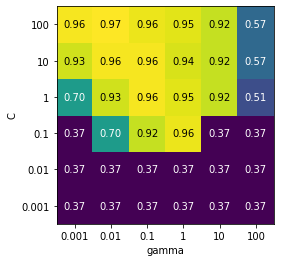

In [36]:
import matplotlib

import mglearn

%matplotlib inline

# さらにヒートマップで可視化
scores = np.array(results.mean_test_score).reshape(6, 6)

# 平均交差検証スコアのプロット
mglearn.tools.heatmap(scores,
                      xlabel="gamma",
                      xticklabels=param_grid["gamma"],
                      ylabel="C",
                      yticklabels=param_grid["C"],
                      cmap="viridis")

### ヒートマップから分かること
- 良い性能を得るためには、パラメータの設定はめっちゃ重要！
	- 40% から 96% まで大きくヘンドしている
- パラメータのレンジは大きくしないと探索が難しい